# Lab 2: Bag of Visual Words Image Classification

Team 3: Zuzanna Szafranowska, Claudia Baca, Quim Comas

The goal in this second lab is improve our bag of visual words from previous lab using:

-  Dense SIFT with different scales.
-  Normalization the descriptors (L2-power norm).
-  SVM classifier instead of KNN classifier.
-  StantardScaler to remove the mean and scale the data. 
-  Cross validation.
-  Different kernels for SVM classifier.
-  Spatial pyramids

Apart from the mandatory tasks we also perform some other mesuares to evaluate our Bow such as confusion matrix, precision, recall or F-score.

In [1]:
import cv2
import numpy as np
import itertools
#inPython3.x:
import pickle as cPickle
#in Python2.x:
#import cPickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler,normalize, Normalizer,PowerTransformer
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import time
# from sklearn.cross_validation import StratifiedKFold



Let us first read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

<h1>Feature extraction, descriptors</h1>

We create detectors and descriptors: SIFT, SURF, ORB

In [3]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
SURFdetector = cv2.xfeatures2d.SURF_create(300)
ORBdetector = cv2.ORB_create()

We choose the type of local feature detector that we want to use. 

- 1 ==> SIFT
- 2 ==> SURF
- 3 ==> ORB
- 4 ==> Dense SIFT
- 5 ==> Dense SURF


In [4]:
k = 1024
#codebook size
x=4
#x = input("Enter a number to choose the local feature detector: ")
L=0
#Enter the number levels of the spatial pyramid (O to L)
norm=0
#Type of normalization of 1 L2 and 2 Power, 0 if none
step_size = 5
#step size of Dense SIFT and SURF
scale=5
#scale of Dense SIFT and SURF


In [5]:
def descriptors(gray,x):
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
    if(x==4):
        kpt = [cv2.KeyPoint(x, y, scale) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SIFTdetector.compute(gray,kpt)
    if(x==5):
        
        kpt = [cv2.KeyPoint(x, y, scale) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SURFdetector.compute(gray,kpt)
    return kpt, des

In [6]:
def normalize(hist1):
    if(norm==1):
        hist2=np.linalg.norm(x, ord=2)
        normhist=hist1 / hist2
    if(norm==2):
        hist=np.linalg.norm(x, ord=2)

    return normhist       

<h1>Bow</h1>

We compute the indicated descriptor for all the train images and subsequently build a numpy array with all the descriptors stacked together, then we   compute a k-means clustering on the descriptor space, where we test 3 different codebook sizes k (64,128,256). And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [7]:
def Bow(train_images_filenames,train_labels):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        kpt,des=descriptors(gray,x)
        
        Train_descriptors.append(des)
        
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    if(norm==1):
        transformer = Normalizer(norm = 'l2')
        temp = transformer.fit(D)
        D = temp.transform(D)
        for i in range(len(Train_descriptors)):
            Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
    elif(norm==2):
        pt=PowerTransformer()
        temp=pt.fit(D)
        D=temp.transform(D)
        for i in range(len(Train_descriptors)):
            Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)): 
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    
    return visual_words, codebook
    
    
    

In [8]:
start = time.time()
visual_words,codebook=Bow(train_images_filenames,train_labels)
end = time.time()
print('Time: {}s.'.format(str(end-start)))

Time: 951.7278108596802s.


<h1>Bow-Spatial Pyramid</h1>

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [16]:
def get_spatialpyramid(train_images_filenames,train_labels,l):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    visualwords=[]
    if(l==0):
        for filename,labels in zip(train_images_filenames,train_labels):
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=descriptors(gray,x)
            Train_descriptors.append(des)   
        D=np.vstack(Train_descriptors)
        if(norm==1):
            transformer = Normalizer(norm = 'l2')
            temp = transformer.fit(D)
            D = temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
        elif(norm==2):
            pt=PowerTransformer()
            temp=pt.fit(D)
            D=temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i])  
        codebook.fit(D)
        visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)): 
            words=codebook.predict(Train_descriptors[i])
            visualwords[i,:]=np.bincount(words,minlength=k)
            
        visual_words=visualwords 
    else:  
        for filename,labels in zip(train_images_filenames,train_labels):
            Train_descriptors = []
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            wstep=np.int(gray.shape[0]/(2**(l)))
            hstep=np.int(gray.shape[1]/(2**(l)))
           
            for u in range(0,gray.shape[0],wstep):
                for f in range(0,gray.shape[1],hstep):  
                    kpt,des=descriptors(gray[u:u+hstep, f:f+wstep],x)
                    Train_descriptors.append(des)
            D=np.vstack(Train_descriptors)        
            weight = 2**(L-l) 
            if(norm==1):
                transformer = Normalizer(norm = 'l2')
                temp = transformer.fit(D)
                D = temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] =weight*temp.transform(Train_descriptors[i]) 
            elif(norm==2):
                pt=PowerTransformer()
                temp=pt.fit(D)
                D=temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] = weight*temp.transform(Train_descriptors[i])          
            visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)    
            for i in range(len(Train_descriptors)): 
                words=codebook.predict(Train_descriptors[i])
                visualwords[i,:]=np.bincount(words,minlength=k)
            weight = 2**(L-l)           
            visual_words.append((visualwords.ravel()))     
    return visual_words,codebook
                        

In [17]:
k = 256
L=0
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
i=0
visual_wordsl0,codebookl0=get_spatialpyramid(train_images_filenames,train_labels,0);
visual_wordsl1,codebook11=get_spatialpyramid(train_images_filenames,train_labels,1);  
        
            

In [18]:
visual_words=[]
for i in range(len(visual_wordsl0)):
    visu=[]
    visu=np.append(visual_wordsl0[i],visual_wordsl1[i])
    visual_words.append(visu)



In [19]:
def get_test_spatialpyramid(test_images_filenames,l):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    visualwords=[]
    if(l==0):
        for i in range(len(test_images_filenames)):
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=descriptors(gray,x)
            Train_descriptors.append(des)   
        D=np.vstack(Train_descriptors)
        if(norm==1):
            transformer = Normalizer(norm = 'l2')
            temp = transformer.fit(D)
            D = temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
        elif(norm==2):
            pt=PowerTransformer()
            temp=pt.fit(D)
            D=temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i])  
        codebook.fit(D)
        visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)): 
            words=codebook.predict(Train_descriptors[i])
            visualwords[i,:]=np.bincount(words,minlength=k)
            
        visual_words=visualwords 
    else:  
        for i in range(len(test_images_filenames)):
            Train_descriptors = []
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            wstep=np.int(gray.shape[0]/(2**(l)))
            hstep=np.int(gray.shape[1]/(2**(l)))
           
            for u in range(0,gray.shape[0],wstep):
                for f in range(0,gray.shape[1],hstep):  
                    kpt,des=descriptors(gray[u:u+hstep, f:f+wstep],x)
                    Train_descriptors.append(des)
            D=np.vstack(Train_descriptors)        
            weight = 2**(L-l) 
            if(norm==1):
                transformer = Normalizer(norm = 'l2')
                temp = transformer.fit(D)
                D = temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] =weight*temp.transform(Train_descriptors[i]) 
            elif(norm==2):
                pt=PowerTransformer()
                temp=pt.fit(D)
                D=temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] = weight*temp.transform(Train_descriptors[i])          
            visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)    
            for i in range(len(Train_descriptors)): 
                words=codebook.predict(Train_descriptors[i])
                visualwords[i,:]=np.bincount(words,minlength=k)
            weight = 2**(L-l)           
            visual_words.append((visualwords.ravel()))     
    return visual_words,codebook


In [20]:
visual_wordsl0test,codebookl0test=get_test_spatialpyramid(test_images_filenames,0)
visual_wordsl1test,codebookl1test=get_test_spatialpyramid(test_images_filenames,1)
visual_words_test=[]
for i in range(len(visual_wordsl0test)):
    visu=[]
    visu=np.append(visual_wordsl0test[i],visual_wordsl1test[i])
    visual_words_test.append(visu)

Before applying the SVM we create the histogram intersection kernel (it is not available in the sklearn library):

In [9]:
def histogram_intersection(M,N):
    M_samples, M_features = M.shape
    N_samples, N_features = N.shape
    
    K_int= np.zeros(shape=(M_samples,N_samples),dtype= np.float)
    for i in range(M_samples):
        for j in range(N_samples):
            K_int[i,j]=np.minimum(M[i,:],N[j,:]).sum()
    
    return K_int

<h1>Cross Validation SVM</h1>

Creating folds for Cross-Validation:

In [10]:
K_cv=3
skf = StratifiedKFold(n_splits=K_cv)

<h1>SVM kernels</h1>
In this step we add the SVM classifier to train our data. Before train our visual words, we preprocess the data standardizing the features by removing the mean and scaling to unit variance. In our implementation we can choose between different types of kernels:

- Linear Kernel --> 'linear'
- Rbf Kernel --> 'rbf'
- Polynomial Kernel --> 'poly'
- Sigmoid Kernel --> 'sigmoid'
- Histogram Intersection Kernel --> 'histogram'

In [11]:
#Choose the type of kernel (histogram by default):

Kernel= 'histogram'

stdSlr= StandardScaler().fit(visual_words)
scaled = stdSlr.transform(visual_words)
start=time.time()
if(Kernel=='linear'):
    clf= svm.SVC(kernel='linear',C=0.01,gamma=0.002)
if(Kernel=='rbf'):
    clf= svm.SVC(kernel='rbf',C=1,gamma=0.002)
if(Kernel=='poly'):
    clf= svm.SVC(kernel='poly',C=1,gamma=1)
if(Kernel=='sigmoid'):
    clf= svm.SVC(kernel='sigmoid',C=1,gamma=0.002)
if(Kernel=='histogram'): 
    clf= svm.SVC(kernel='precomputed',C=0.01) 
        
folds = list(skf.split(scaled, train_labels))
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    train_labels=np.asarray(train_labels)

    scaled_train, scaled_valid = scaled[train_idx], scaled[test_idx]
    labels_train, labels_valid = train_labels[train_idx], train_labels[test_idx]

    if(Kernel=='histogram'): 
        kernel=histogram_intersection(scaled_train,scaled_train)
        clf.fit(kernel,labels_train)  
    else:
        clf.fit(scaled_train,labels_train)

    if(Kernel!='histogram'):
        accuracy = 100*clf.score(scaled_valid, labels_valid)
        print(accuracy)
end=time.time()
print('Time: {}s.'.format(str(end-start)))
        



===================FOLD= 0

===================FOLD= 1

===================FOLD= 2
Time: 85.15749788284302s.


<h1>Optimal k value and cross validation for KNN</h1>

To see the effect of K value in KNN classifier we perform a 10 fold cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

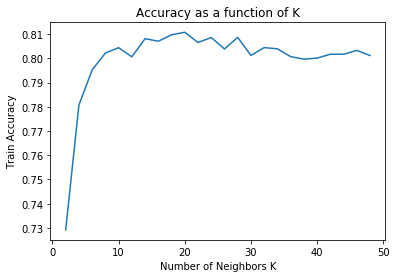

The optimal k value is 20


In [21]:
neighbors = list(filter(lambda x: x % 2 == 0, list(range(1,50))))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='braycurtis')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('Accuracy as a function of K')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()
#python2.x
#print("The optimal k value is %d" % optimal_k)
#python3.x
print("The optimal k value is %d" % optimal_k)

We build a k-nn classifier and train it with the train descriptors

In [27]:
folds = skf.split(visual_words, train_labels)
knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1,metric='braycurtis')

for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    train_labels=np.asarray(train_labels)

    visual_words_train=[visual_words[j] for j in train_idx]
    visual_words_valid =[visual_words[j] for j in test_idx]
    labels_train, labels_valid = train_labels[train_idx], train_labels[test_idx]
    knn.fit(visual_words_train, labels_train) 
    accuracy = 100*knn.score(visual_words_valid, labels_valid)
    print(accuracy)
end=time.time()
print('Time: {}s.'.format(str(end-start)))


===================FOLD= 0
78.92234548335975

===================FOLD= 1
81.3397129186603

===================FOLD= 2
77.52808988764045
Time: 1543.3036487102509s.


<h1>Test descriptors</h1>

We end up computing the test descriptors for the svm:

In [25]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    kpt,des=descriptors(gray,x)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

<h1>Evaluation</h1>

In the next step we perform the confusion matrix to evaluate our classifier with respect the 8 image classes:

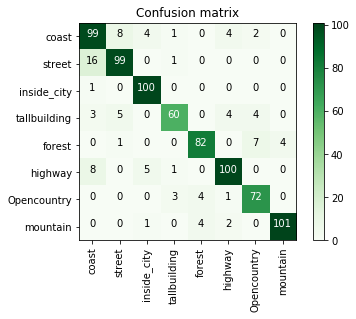

In [13]:
classes = list(set(test_labels))

if(Kernel== 'histogram'):
    predict= histogram_intersection(stdSlr.transform(visual_words_test),scaled_train)
    predictions= clf.predict(predict)
else:
    predictions= clf.predict(stdSlr.transform(visual_words_test))

conf_matrix= confusion_matrix(test_labels,predictions)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")


To obtain more information about our classification we compute other mesuares like precision, recall and f-score to complement the confusion matrix and the accuracy:

In [14]:
precision, recall, fscore, support= precision_recall_fscore_support(test_labels, predictions,average='macro')

print (precision*100)
print (recall*100)
print (fscore*100)

88.68488961716734
88.20903267492855
88.3375890541777


Finally, we compute the accuracy for SVM:

In [15]:
if Kernel == 'histogram':
    accuracy_svm = 100*clf.score(predict, test_labels)
else:
    accuracy_svm = 100*clf.score(stdSlr.transform(visual_words_test), test_labels)
print(accuracy_svm)

88.35192069392814


<h1>Conclusions</h1>



Finally, in this last section we will expose all results and conclusions of this second lab. 


First of all, we will focus on SVM classifier and SVM Kernels. In this second lab, we have changed the KNN classifier for the SVM classifier, which has caused an improvement in terms of accuracy. To analyse in more depth the different SVM Kernels we define an initial parameters to see the effects of the different parameters. 

The different SVM kernels that we have implemented are: Linear kernel, Radial basis function kernel, Polynomial kernel, Sigmoid kernel and finally we have performed a custom kernel which consists in histogram intersection kernel. 

Respect to our initial parameter are: Codebook size of 256 using Dense Sift (the best descriptor from lab1) and then we have the parameter C equal to 1, which controls the decision surface, and gamma equal to 0.002 which defines how much influence a single training example.


- Using initial parameters: 

    Codebook = 256;
    Trade off C=1;
    Gamma=0.002;
    Dense SIFT


| Kernels | Accuracy | CV time |
| --- | --- |--- |
| Linear |  82.2800 | 1.1656 s |
| Radial Basis Function |  84.0148 | 1.7813 s |
| Polynomial |  36.4312 | 3.1022 s |
|  Sigmoid |  82.6517 | 1.5055 s |
| Histogram intersection |  85.7496 | 61.7647 s | 

As we can see in the previous table all the kernels work very well except the Polynomial kernel. The best accuracy value that we have obtained is using histogram intersection with 85.7496. In this process we have used cross validation (same for KNN) to ensure data independence between the training and the test (overfitting).

Now in the following table we can see the evolution of the SVM kernels with respect the parameter C:

- Changing the parameter C: 

| Kernels | Accuracy, C=0.001  | Accuracy, C=0.01  | Accuracy, C=0.1 | Accuracy, C=0.5 |
| --- | --- |--- |--- |
| Linear | 81.9083 |84.0148 | 82.5278 | 82.2800 |
| Radial Basis Function | 14.6220 |  14.6220 | 14.6220 | 82.7757|
| Polynomial | 14.6220 | 14.6221 | 14.6220 | 26.2701 |
| Sigmoid | 14.6220 | 14.6220 | 14.6220 | 26.2701 |
| Histogram intersection | 81.1648| 85.9975 | 85.7496 | 85.7496 |  

Looking the previous table, we can conclude that the linear kernel and histogram intersection kernel improve slightly with respect to the accuracy using the initial parameters. However, the others Kernels don't work well with C less than 1.

In the evolution of the SVM kernels with respect the parameter gamma we have:

- Changing the parameter gamma: 

| Kernels | Accuracy, gamma=0.0001  | Accuracy, gamma=0.01  | Accuracy, gamma=0.1 | Accuracy, gamma=1 |
| --- | --- |--- |--- |
| Linear | 82.2800 |82.2800 | 82.2800 | 82.2800 |
| Radial Basis Function | 74.3494 |  81.0408 | 14.6220 | 14.6220|
| Polynomial | 14.6220 | 79.0582 | 79.1821 | 79.1821|
| Sigmoid | 59.1078 | 71.7472 | 39.5291 | 39.9008|
| Histogram intersection | 85.7496 | 85.7496 | 85.7496 | 85.7496 | 

In this case, we can notice that the gamma parameter not have any effect to linear and histogram intersection kernel. On the other hand, the rest of the kernels have an optimal value between 0.0001 and 0.01 which correspond approximately to the initial parameter gamma=0.002.

- Using optimal values for C and gamma from previous tables:

| Kernels | Accuracy | Final parameters | CV time |
| --- | --- |--- |--- |
| Linear |  82.5278 | C= 0.01; gamma= 0.002| 1.2401 s |
| Radial Basis Function |  84.0148 |C= 1 ; gamma= 0.002| 1.7813 s |
| Polynomial |  79.1821 |C= 1 ; gamma= 1 | 29.4810 s |
|  Sigmoid|  82.6517 | C= 1; gamma= 0.002| 1.5055 s |
| Histogram intersection |  85.9975 | C= 0.01; gamma= 0.002| 59.8077 s |

Finally, in the last table about kernels we summarize the different kernels that we have tested and using the information of the last two tables about C and gamma we have found our optimal value for each kernel. Looking the different results, we can see that the histogram intersection kernel provides the best results 85.9975% followed by the sigmoid and linear kernels (in the rest of results we have used by default the histogram intersection kernel).

Before continue with SIFT scale we want to highlight that in our case we don't use the normalization of the descriptors because we have obtained a worse result. Although we expected a growth of the accuracy we obtain a 74.7211% of accuracy (853.00 s) using l2 norm, for this reason we have decided to not use the normalization of the data (norm=0).

Now in the next table we have focused in the Dense Sift descriptor and the evolution through different scales (we have used a tiny step size of 5).

| DSIFT scale | Accuracy | Execution time |
| --- | --- |--- |
| 3  |  85.1301 |  318.44 s |
| 5  |  85.9975 |  531.40 s |
| 7  |  86.6171 |  711.20 s |
| 10 |  84.5102 | 1074.69 s |

What we can appreciate is that increasing the scale of dense Sift we can obtain better results (at the same time that execution time increase) where we have found an optimal value around 7 scales approximately.

The following parameter is the codebook size where we can see a similar evolution respect to Dense Sift scales. Increasing the size of the codebook we can notice an improvement of the accuracy but it causes a high execution time (for instance, 1024 size with 1808.38 s).

| Codebook size | Accuracy | Execution time |
| --- | --- |--- |
| 128 |  83.3952 |  462.44 s |
| 256 |  85.9975 |  531.40 s |
| 512 |  87.2366 | 1092.52 s |
| 1024|  88.3519 | 1808.38 s |

We have also tried to combine the best result for kernels, Dsift scales and codebook but we have obtained the same result increasing more the execution time.

Therefore, the best result that we obtain during this second lab was using:

- SVM classifier and histogram intersection kernel (C=0.01). 
- Dense Sift with tiny step size of 5 and 5 scales (instead of 7 to reduce the execution time).
- Cross validation to prevent overfitting.
- Codebook size of 2^10 (1024).

And the best accuracy result is  **88.3519 %** .

An important conclusion that we can extract thanks to confusion matrix (that we can see in evaluation section) is that in most cases we obtain a great result except in two or three classes. One possible reason to explain this difference between these two or three classes and the rest is that these datasets are very similar so it's very difficult to classify them perfectly (for instance, tallbuiding and inside_city or forest and opencountry). A possible solution in this case are spatial pyramids to recover the spatial information, however, we haven't obtained the desired values using spatial pyramids.

As we have seen one of the disadvantages of Bag of Visual Worlds, it’s that the encoding of the feature extraction discards the spatial information of the words, to try to fix that we have implemented the Spatial Pyramids. This technique consists in performing the descriptors computed in the last lab in different layers of each the image, being L=0 the complete image, L=1 the image segmented in 2^2*L … For each region of the layers the descriptors are computed and the words are extracted, then all the histograms of the layers are concatenated in one vector. Our implementation is computationally expensive because we go over all the images more than once, so it takes a lot of time if we use L>1. Regarding the accuracy, although the implementation is correct we were not able to compute correctly the accuracy that we get for L>0, we keep getting errors that the words are not classified getting then low accuracy like 10-12%  for each SVM kernel, each codebook size…


To sum up all the conclusions:

- SVM classifier improves the accuracy of Bow with respect to KNN classifier.
- Histogram intersection kernel with C=0.001 gave us the best perfomance.
- We expected an improvement using normalize descriptors but we obtained 10% accuracy less. 
- Using cross validation we can control the indepence between training an test sets.
- Increasing the scales of Dense Sift we improve slihgtly the accuracy (optimal value in our case around 7).
- A codebook size between 2^9 and 2^11 improves the perfomance of our classification.
- Similar classes in the dataset are difficult to classify perfectly.
- Although we didn't achieve good results with spatial pyramids we think that can provide a better accuracy using spatial information. 
